# Reaction Wheel Momentum Time-Series Demo

This notebook simulates multiple slews driven by the ACS and plots reaction-wheel stored momentum over time.


/home/aaron/Projects/Cosmic/ops/coast-sim/coastvenv/lib/python3.13/site-packages/astropy/config/paths.py:55: AstropyUserWarning: XDG_CONFIG_HOME is set to '/home/aaron/.var/app/com.visualstudio.code/config', but the default location, /home/aaron/.astropy/config, already exists, and takes precedence. This environment variable will be ignored.
  return set_temp_config._get_dir_path(rootname)
EOP2 text loaded from cache: /home/aaron/.cache/rust_ephem/latest_eop2.short (age: 40829s)
UT1 provider initialized (EOP2 short, cached)


Number of pointings = 1000


100%|██████████| 1000/1000 [00:00<00:00, 3822.37it/s]
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
f

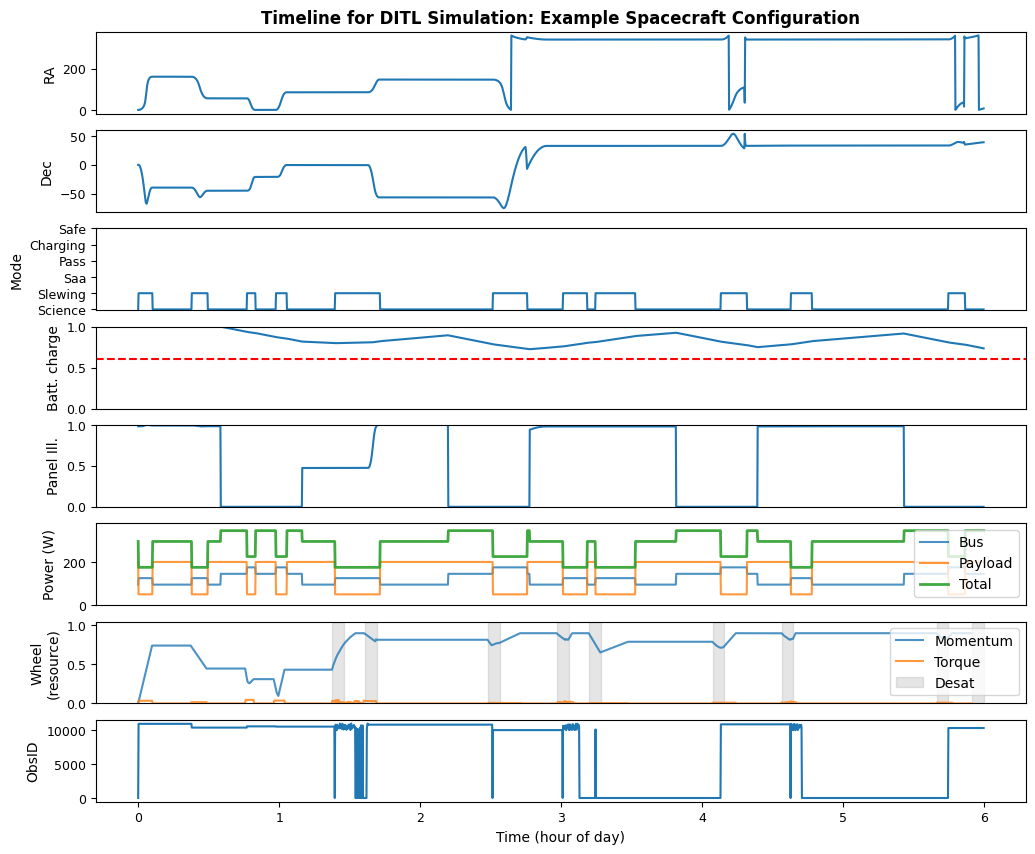

In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from conops import MissionConfig, Queue, Pointing, QueueDITL
from conops.visualization import plot_ditl_telemetry
from rust_ephem import TLEEphemeris
import numpy as np
from tqdm import tqdm

# Load config and set inertia + wheel set
cfg = MissionConfig.from_json_file("../example_config.json")
cfg.spacecraft_bus.attitude_control.spacecraft_moi = (45.0, 45.0, 45.0)
cfg.spacecraft_bus.attitude_control.wheel_enabled = False  # use multi-wheel list
cfg.spacecraft_bus.attitude_control.wheels = [
    {"name": "rw1", "orientation": (+1,+1,+1), "max_torque": 0.06, "max_momentum": 1},
    {"name": "rw2", "orientation": (+1,-1,-1), "max_torque": 0.06, "max_momentum": 1},
    {"name": "rw3", "orientation": (-1,+1,-1), "max_torque": 0.06, "max_momentum": 1},
    {"name": "rw4", "orientation": (-1,-1,+1), "max_torque": 0.06, "max_momentum": 1},
]

# Configure 3 orthogonal magnetorquers (default B field is 3e-5 T; override if you want)
cfg.spacecraft_bus.attitude_control.magnetorquers = [
    {"name": "mtq_x", "orientation": (1, 0, 0), "dipole_strength": 32, "power_draw": 5.0},
    {"name": "mtq_y", "orientation": (0, 1, 0), "dipole_strength": 32, "power_draw": 5.0},
    {"name": "mtq_z", "orientation": (0, 0, 1), "dipole_strength": 32, "power_draw": 5.0},
]
cfg.spacecraft_bus.attitude_control.magnetorquer_bfield_T = 3e-5  # optional override

acs = cfg.spacecraft_bus.attitude_control
acs.cp_offset_body = (0.25, 0.0, 0.0)            # m
acs.residual_magnetic_moment = (0.05, 0, 0)      # A·m^2
acs.drag_area_m2 = 1.3 # m2
acs.drag_coeff = 2.2
acs.solar_area_m2 = 1.3
acs.solar_reflectivity = 1.3
cfg.spacecraft_bus.attitude_control.use_msis_density = True


begin = datetime(2025, 1, 1)
end = begin + timedelta(hours=6)
ephem = TLEEphemeris(tle="../example.tle", begin=begin, end=end, step_size=10)
cfg.constraint.ephem = ephem  # ensure ephem is set for PlanEntry/Pointing

# Build a busy queue
queue = Queue(config=cfg, ephem=ephem)
queue.slew_distance_weight = 40.0


number_of_targets = 1000
target_ra, target_dec = (
    np.random.uniform(0, 360, number_of_targets),
    np.random.uniform(-90, 90, number_of_targets),
)
print(f"Number of pointings = {len(target_ra)}")

targids = list(range(10000, 10000 + len(target_ra)))

targlist = Queue(
    ephem=ephem,
    config=cfg,
)
for i in tqdm(range(len(targids))):
    targlist.add(
        merit=40,
        ra=target_ra[i],
        dec=target_dec[i],
        obsid=targids[i],
        name=f"pointing_{targids[i]}",
        exptime=1000,
        ss_min=300,
    )


ditl = QueueDITL(config=cfg, ephem=ephem, begin=begin, end=end, queue=targlist)
ditl.step_size = 10  # seconds
ditl.calc()

fig, axes = plot_ditl_telemetry(ditl, figsize=(12, 10))
plt.show()



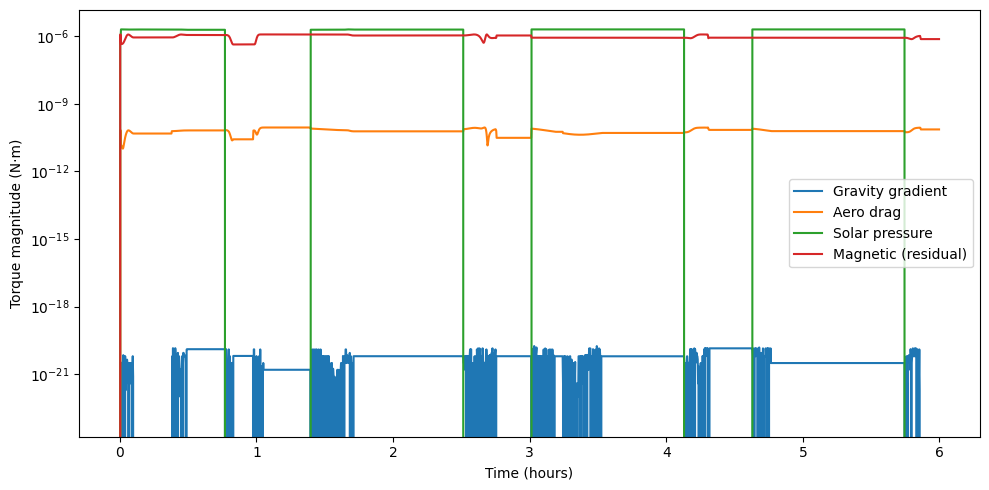

In [2]:
import numpy as np
import matplotlib.pyplot as plt

time_hours = (np.array(ditl.utime) - ditl.utime[0]) / 3600

plt.figure(figsize=(10,5))
#plt.plot(time_hours, ditl.disturbance_total, label="Total")
plt.plot(time_hours, ditl.disturbance_gg, label="Gravity gradient")
plt.plot(time_hours, ditl.disturbance_drag, label="Aero drag")
plt.plot(time_hours, ditl.disturbance_srp, label="Solar pressure")
plt.plot(time_hours, ditl.disturbance_mag, label="Magnetic (residual)")
plt.xlabel("Time (hours)")
plt.ylabel("Torque magnitude (N·m)")
plt.legend()
plt.yscale("log")
plt.tight_layout()
plt.show()


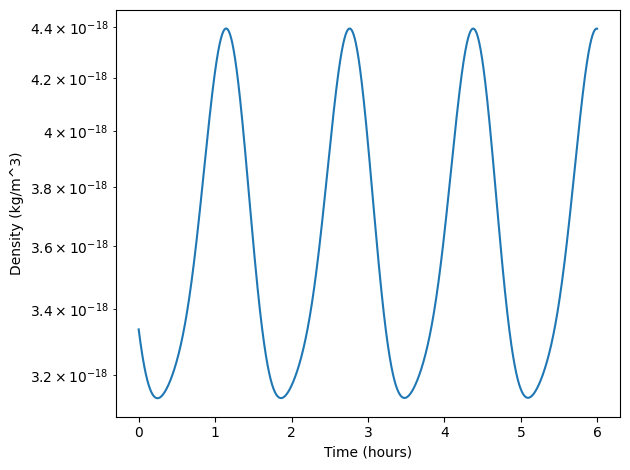

In [3]:
import numpy as np
from datetime import datetime, timezone

# enable MSIS
cfg.spacecraft_bus.attitude_control.use_msis_density = True

# after your DITL calc:
acs = ditl.acs
ephem = ditl.ephem

densities = []
alts_km = []
for ut in ditl.utime:
    idx = ephem.index(datetime.fromtimestamp(ut, tz=timezone.utc))
    r_vec = np.array(ephem.gcrs_pv.position[idx])
    # normalize to meters if in km
    if np.linalg.norm(r_vec) < 1e6:
        r_vec = r_vec * 1000.0
    alt_m = max(0.0, np.linalg.norm(r_vec) - 6378e3)
    lat = float(getattr(ephem, "lat", [0])[idx]) if hasattr(ephem, "lat") else 0.0
    lon = float(getattr(ephem, "long", [0])[idx]) if hasattr(ephem, "long") else 0.0
    rho = acs._atmospheric_density(ut, alt_m, lat, lon)
    densities.append(rho)
    alts_km.append(alt_m / 1000.0)

# Plot density vs time
import matplotlib.pyplot as plt
time_hours = (np.array(ditl.utime) - ditl.utime[0]) / 3600
plt.semilogy(time_hours, densities)
plt.xlabel("Time (hours)")
plt.ylabel("Density (kg/m^3)")
plt.tight_layout()
plt.show()


In [10]:
acs = ditl.acs
acs._use_msis = True  # ensure MSIS path
ut0 = ditl.utime[0]
idx = ditl.ephem.index(datetime.fromtimestamp(ut0, tz=timezone.utc))
r = np.array(ditl.ephem.gcrs_pv.position[idx])
if np.linalg.norm(r) < 1e6: r = r*1000
alt = np.linalg.norm(r) - 6378e3
lat = float(getattr(ditl.ephem, "lat", [0])[idx])
lon = float(getattr(ditl.ephem, "long", [0])[idx])
rho = acs._atmospheric_density(ut0, alt, lat, lon)
print(f"alt={alt/1000:.1f} km rho={rho:.3e} kg/m^3")


alt=617.3 km rho=3.336e-18 kg/m^3


In [6]:
alt

np.float64(617322.1818093546)

In [2]:
ditl.print_statistics()

DITL SIMULATION STATISTICS

Configuration: Example Spacecraft Configuration
Start Time: 2025-01-01 00:00:00 UTC
End Time: 2025-01-01 06:00:00 UTC
Duration: 6.00 hours (0.25 days)
Time Steps: 2160
Step Size: 10 seconds

----------------------------------------------------------------------
MODE DISTRIBUTION
----------------------------------------------------------------------
Mode                 Count      Percentage   Time (hours)   
----------------------------------------------------------------------
SCIENCE              1631        75.51%            4.53
SLEWING              529         24.49%            1.47

----------------------------------------------------------------------
OBSERVATION STATISTICS
----------------------------------------------------------------------
Total Unique Observations: 153
Total Observation Steps: 2159

Top 10 Observations by Time:
ObsID      Steps      Time (hours)   
-----------------------------------
1          1066             2.96
10294      17

DESAT windows: [(1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300.0), (1735691810.0, 300

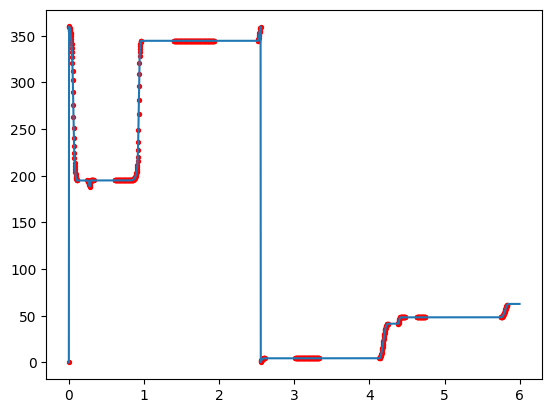

In [12]:
from conops.common import ACSCommandType, ACSMode
time_h = (np.array(ditl.utime) - ditl.utime[0]) / 3600
slew_cmds = [c for c in ditl.acs.executed_commands if c.command_type == ACSCommandType.SLEW_TO_TARGET]
desat_cmds = [c for c in ditl.acs.executed_commands if c.command_type == ACSCommandType.DESAT]
print("DESAT windows:", [(c.execution_time, getattr(c, "duration", None)) for c in desat_cmds])

# Overlay where mode==SLEWING to see it spans settle/desat
import matplotlib.pyplot as plt
m = np.array(ditl.mode)
plt.plot(time_h, ditl.ra)
plt.scatter(time_h[m == ACSMode.SLEWING], np.array(ditl.ra)[m == ACSMode.SLEWING], s=8, color="r")


In [13]:
from conops.common import ACSCommandType

cmds = [c for c in ditl.acs.executed_commands if c.command_type == ACSCommandType.SLEW_TO_TARGET]
for c in cmds:
    dist = c.slew.slewdist          # deg along great circle
    t = c.slew.slewtime             # s (includes settle)
    avg_rate = dist / t if t else 0
    a = getattr(c.slew, "_accel_override", None)
    vmax = getattr(c.slew, "_vmax_override", None)
    print(f"obsid={c.slew.obsid} dist={dist:.2f}deg time={t:.1f}s avg={avg_rate:.3f} deg/s accel={a} vmax={vmax}")


obsid=10336 dist=152.81deg time=403.0s avg=0.379 deg/s accel=0.003967293265295515 vmax=2.5118479595392555
obsid=10484 dist=53.26deg time=304.0s avg=0.175 deg/s accel=1.1334304968818378e-18 vmax=1.081921140583483
obsid=10275 dist=116.56deg time=927.0s avg=0.126 deg/s accel=7.371798820855529e-10 vmax=1.1541606606244437
obsid=10128 dist=73.86deg time=535.0s avg=0.138 deg/s accel=0.0010738238489617696 vmax=1.2868028385313237
obsid=10610 dist=22.84deg time=125.0s avg=0.183 deg/s accel=0.006962149127278341 vmax=1.5945945880070553
obsid=10768 dist=10.07deg time=71.0s avg=0.142 deg/s accel=0.01077485318316231 vmax=1.8380491498057097
obsid=10129 dist=76.73deg time=386.0s avg=0.199 deg/s accel=0.0021719450171562853 vmax=1.7698693296804993
obsid=10805 dist=13.51deg time=89.0s avg=0.152 deg/s accel=0.008684543408726604 vmax=1.7675095610359008
obsid=10720 dist=23.35deg time=126.0s avg=0.185 deg/s accel=0.007001385795233791 vmax=1.5878041964923102
obsid=10380 dist=9.42deg time=85.0s avg=0.111 deg/s 

In [14]:
import numpy as np
from conops.common import separation

# great-circle step-to-step rate
rates = []
for i in range(1, len(ditl.ra)):
    r = separation(
        [np.deg2rad(ditl.ra[i-1]), np.deg2rad(ditl.dec[i-1])],
        [np.deg2rad(ditl.ra[i]),   np.deg2rad(ditl.dec[i])]
    ) # deg
    d = np.rad2deg(r)
    rates.append(d / ditl.step_size)  # deg/s
print("Max step rate:", max(rates), "deg/s")


Max step rate: 0.7669818249638085 deg/s


In [15]:
import numpy as np
from conops.common import ACSCommandType
dists = [c.slew.slewdist for c in ditl.acs.executed_commands
         if c.command_type == ACSCommandType.SLEW_TO_TARGET and c.slew]
print("mean dist:", np.mean(dists), "deg", "max:", np.max(dists), "deg")


mean dist: 56.35802176614315 deg max: 152.81311491161594 deg


In [16]:
import numpy as np
from conops.common import ACSCommandType, separation

# Slew distances actually flown
dists = [c.slew.slewdist for c in ditl.acs.executed_commands
         if c.command_type == ACSCommandType.SLEW_TO_TARGET and c.slew]
print(f"Count={len(dists)}, mean={np.mean(dists):.1f} deg, median={np.median(dists):.1f}, max={np.max(dists):.1f}")

# Time in SLEWING
mode_array = np.array(ditl.mode)
frac_slewing = np.mean(mode_array == 1) * 100
print(f"SLEWING fraction: {frac_slewing:.1f}%")

# Effective accel/rate per slew
for c in ditl.acs.executed_commands:
    if c.command_type == ACSCommandType.SLEW_TO_TARGET and c.slew:
        print(f"obsid={c.slew.obsid} dist={c.slew.slewdist:.1f} deg, "
              f"accel={getattr(c.slew,'_accel_override',None)}, "
              f"vmax={getattr(c.slew,'_vmax_override',None)}")


Count=153, mean=56.4 deg, median=56.0, max=152.8
SLEWING fraction: 32.2%
obsid=10336 dist=152.8 deg, accel=0.003967293265295515, vmax=2.5118479595392555
obsid=10484 dist=53.3 deg, accel=1.1334304968818378e-18, vmax=1.081921140583483
obsid=10275 dist=116.6 deg, accel=7.371798820855529e-10, vmax=1.1541606606244437
obsid=10128 dist=73.9 deg, accel=0.0010738238489617696, vmax=1.2868028385313237
obsid=10610 dist=22.8 deg, accel=0.006962149127278341, vmax=1.5945945880070553
obsid=10768 dist=10.1 deg, accel=0.01077485318316231, vmax=1.8380491498057097
obsid=10129 dist=76.7 deg, accel=0.0021719450171562853, vmax=1.7698693296804993
obsid=10805 dist=13.5 deg, accel=0.008684543408726604, vmax=1.7675095610359008
obsid=10720 dist=23.4 deg, accel=0.007001385795233791, vmax=1.5878041964923102
obsid=10380 dist=9.4 deg, accel=0.006755098640533613, vmax=1.6366396079849654
obsid=10542 dist=21.9 deg, accel=0.006574649385063632, vmax=1.4897912897030867
obsid=10763 dist=15.2 deg, accel=0.004340109976392887,

In [17]:
import numpy as np
from conops.common import ACSMode

mode_arr = np.array(ditl.mode)
science_frac = np.mean(mode_arr == ACSMode.SCIENCE) * 100
slew_frac = np.mean(mode_arr == ACSMode.SLEWING) * 100
print(f"SCIENCE: {science_frac:.1f}%")
print(f"SLEWING: {slew_frac:.1f}%")


SCIENCE: 67.8%
SLEWING: 32.2%
